In [1]:
# https://www.cs.yale.edu/homes/el327/datamining2013aFiles/07_singular_value_decomposition.pdf

In [29]:
%matplotlib notebook
import matplotlib
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import axes3d

import h5py
import time
from tqdm import tqdm
import numpy as np
import pandas as pd
import MDAnalysis as mda
from pathlib import Path
from tqdm import tqdm
from numba import jit
from collections import defaultdict
from sklearn.cluster import KMeans
from mdlearn.data.preprocess.align import iterative_means_align

from typing import TYPE_CHECKING, Tuple, Dict, List, Optional

if TYPE_CHECKING:
    import numpy.typing as npt
    
# Set random seed
np.random.seed(0)

output_path = Path("/homes/abrace/src/CMSC-35300-Final-Project/results")
output_path.mkdir(exist_ok=True)

In [31]:
%matplotlib inline

LABEL_FONTSIZE = 20

def show_scatter(data: np.ndarray, color: np.ndarray):
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    ax.set_facecolor('white')
    ff = ax.scatter(data[:, 0], data[:, 1], data[:, 2], c=color)
    plt.colorbar(ff)
    plt.show()
    
def plot_scatter_mpl(
    data: np.ndarray,
    color: np.ndarray,
    cbar_pad: float = 0.1,
    cbar_label: str = "",
    cmap: str = "plasma",
    cbar_min: float = None,
    cbar_max: float = None,
    z1_min_max: Optional[Tuple[float, float]] = None,
    z2_min_max: Optional[Tuple[float, float]] = None,
    z3_min_max: Optional[Tuple[float, float]] = None,
):
    
    z1, z2, z3 = data[:, 0], data[:, 1], data[:, 2]
    z1_min_max = z1_min_max if z1_min_max is not None else (np.min(z1), np.max(z1))
    z2_min_max = z2_min_max if z2_min_max is not None else (np.min(z2), np.max(z2))
    z3_min_max = z3_min_max if z3_min_max is not None else (np.min(z3), np.max(z3))


    fig = plt.figure()
    ax = fig.add_subplot(111, projection="3d")
    vmin = cbar_min if cbar_min is not None else np.min(color)
    vmax = cbar_max if cbar_max is not None else np.max(color)
    cnorm = matplotlib.colors.Normalize(
        vmin=vmin, vmax=vmax
    )
    scalar_map = matplotlib.cm.ScalarMappable(norm=cnorm, cmap=plt.get_cmap(cmap))
    scalar_map.set_array(color)
    fig.colorbar(scalar_map, pad=cbar_pad).set_label(label=cbar_label,size=LABEL_FONTSIZE)
    c = scalar_map.to_rgba(color)

    ax.scatter3D(z1, z2, z3, marker=".", c=c)
    ax.set_xlim3d(z1_min_max)
    ax.set_ylim3d(z2_min_max)
    ax.set_zlim3d(z3_min_max)
    ax.set_xlabel(r"$z_1$", fontsize=LABEL_FONTSIZE)
    ax.set_ylabel(r"$z_2$", fontsize=LABEL_FONTSIZE)
    ax.set_zlabel(r"$z_3$", fontsize=LABEL_FONTSIZE)
    plt.tight_layout()
    plt.show()

In [13]:
@jit(nopython=True, parallel=True, fastmath=True)
def power_method(
    A: "npt.NDArray[np.float64]", iterations: int
) -> Tuple["npt.NDArray[np.float64]", "np.float64", "npt.NDArray[np.float64]"]:
    
    n, p = A.shape

    # Pick random vector to initialize the sequence
    # Using uniform distribution instead of normal
    # So that the code can be numba-jit compatible
    v = np.random.random(size=p)
    
    # Precompute transformation
    C = A.T.dot(A)
    
    for i in range(iterations):
        v = C.dot(v)

    v /= np.linalg.norm(v)
    u = A.dot(v)
    s = np.linalg.norm(u)
    u /= s

    return u, s, v

@jit(nopython=True, parallel=True, fastmath=True)
def svd(
    A: "npt.NDArray[np.float64]",
    delta: float = 0.001,
    epsilon: float = 0.97,
    _lambda: float = 2
) -> Tuple["npt.NDArray[np.float64]", "npt.NDArray[np.float64]", "npt.NDArray[np.float64]"]:
    
    n, p = A.shape
    max_rank = min(n, p)
    U = np.zeros((n, n), dtype=np.float64)
    S = np.zeros((n, p), dtype=np.float64)
    V = np.zeros((p, p), dtype=np.float64)
    
    # Iterations for computing the power-method
    iterations = int(np.log(4 * np.log(2 * p / delta) / (epsilon * delta)) / (2 * _lambda))
    
    # Only loop up to the maximum possible rank
    for i in range(max_rank):
        u, s, v = power_method(A, iterations)
        A -= s * np.outer(u, v)
        U[i], S[i, i], V[i] = u, s, v
    
    # Need to return U.T since we are storing the computed columns 
    # row-wise for efficiency
    return U.T, S, V

In [14]:
def _test_power_method(A: np.ndarray):
    
    n, p = A.shape
    delta = 0.001
    epsilon = 0.97
    _lambda = 2

    iterations = int(np.log(4 * np.log(2 * p / delta) / (epsilon * delta)) / (2 * _lambda))
    
    print("A:", A)
    my_u, my_s, my_v = power_method(A.copy(), iterations)
    u, s, vh = np.linalg.svd(A.copy())
    print(f"U Actual: {my_u}, True: {u[0]}")
    print(f"S Actual: {my_s}, True: {s[0]}")
    print(f"V Actual: {my_v}, True: {vh[0]}")
    print("\n")

def test_power_method():
    A = np.array(([1, 2, 3], [4, 5, 6]), dtype=np.float64)
    _test_power_method(A)
    
    A = np.array(([1, 2], [4, 5]), dtype=np.float64)
    _test_power_method(A)
    
def _test_svd(A: np.ndarray):
    print("A:", A)
    my_u, my_s, my_v = svd(A.copy())
    u, s, vh = np.linalg.svd(A.copy())
    print(f"U Actual: {my_u} \nTrue: {u}\n")
    print(f"S Actual: {my_s} \nTrue: {s}\n")
    print(f"V Actual: {my_v} \nTrue: {vh}\n")
    print("Recon:", my_u @ my_s @ my_v)
    print("\n")
    
def test_svd():
    A = np.array([[1, 2, 3], [4, 5, 6]], dtype=np.float64)
    _test_svd(A)
    
    A = np.array([[1, 2], [4, 5]], dtype=np.float64)
    _test_svd(A)
    
    A = np.array([[1, 2], [3, 4], [5, 6]], dtype=np.float64)
    _test_svd(A)
    
test_power_method()
test_svd()

A: [[1. 2. 3.]
 [4. 5. 6.]]
U Actual: [0.38631813 0.9223656 ], True: [-0.3863177   0.92236578]
S Actual: 9.508032000541789, True: 9.508032000695724
V Actual: [0.42866253 0.56630628 0.70395002], True: [-0.42866713 -0.56630692 -0.7039467 ]


A: [[1. 2.]
 [4. 5.]]
U Actual: [0.3245357  0.94587345], True: [-0.32453643 -0.9458732 ]
S Actual: 6.767828935174513, True: 6.767828935632369
V Actual: [0.60700292 0.7946996 ], True: [-0.60699365 -0.79470668]


A: [[1. 2. 3.]
 [4. 5. 6.]]
U Actual: [[ 0.38631477 -0.92255147]
 [ 0.92236701  0.38587405]] 
True: [[-0.3863177   0.92236578]
 [-0.92236578 -0.3863177 ]]

S Actual: [[9.50803199 0.         0.        ]
 [0.         0.77286972 0.        ]] 
True: [9.508032   0.77286964]

V Actual: [[ 0.42869864  0.56631131  0.70392398]
 [ 0.80594715  0.11236027 -0.5812266 ]
 [ 0.          0.          0.        ]] 
True: [[-0.42866713 -0.56630692 -0.7039467 ]
 [-0.80596391 -0.11238241  0.58119908]
 [ 0.40824829 -0.81649658  0.40824829]]

Recon: [[1. 2. 3.]
 [4. 

In [15]:
my_times, np_times = [], []

n_vals = [10 ** i for i in range(1, 4)]

for n in tqdm(n_vals):
    A = np.random.normal(size=(n, n))
    B = A.copy()
    
    # Time my implementation
    start = time.time()
    svd(A)
    stop = time.time()
    my_times.append(stop - start)
    
    # Time numpy implementation
    start = time.time()
    np.linalg.svd(B)
    stop = time.time()
    np_times.append(stop - start)
    
    

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:05<00:00,  1.73s/it]


In [16]:
# With opt
df = pd.DataFrame({"Our Implementation": my_times, "Numpy": np_times, "N": n_vals})
df

Our Implementation     Numpy     N
0            0.004829  0.000138    10
1            0.066889  0.004605   100
2            4.894257  0.201053  1000

<IPython.core.display.Javascript object>


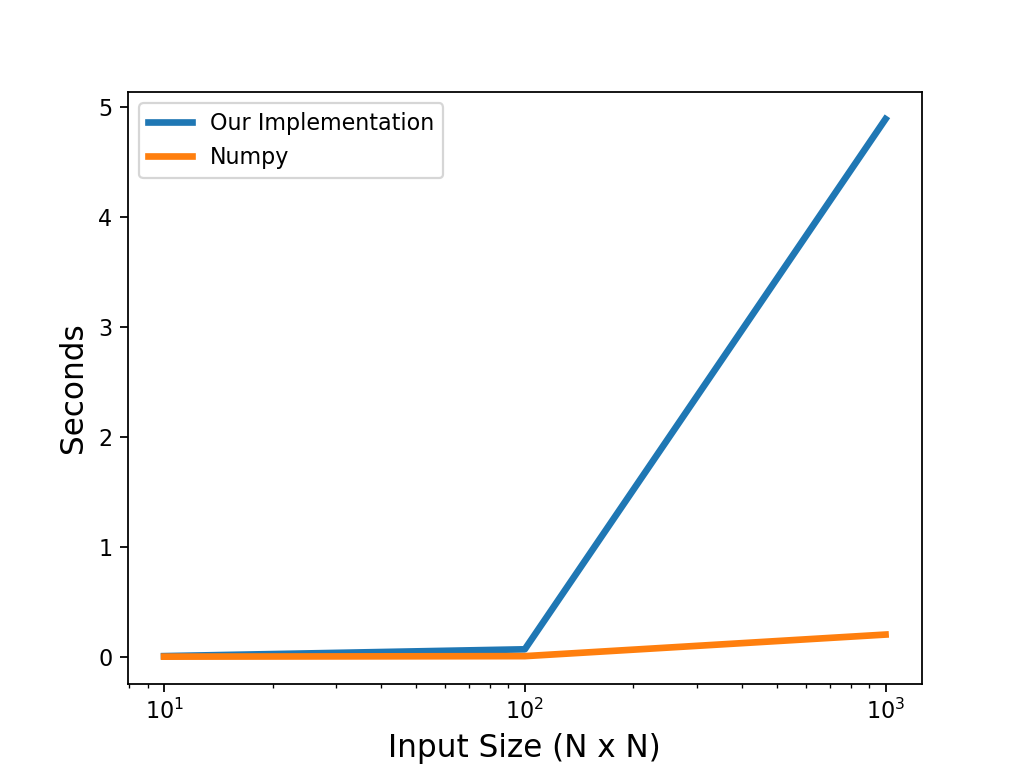

In [17]:
df.plot(x="N", logx=True, linewidth=3)
plt.xlabel("Input Size (N x N)", fontsize=14)
plt.ylabel("Seconds", fontsize=14)
plt.show()

In [18]:
with h5py.File("/homes/abrace/data/bba/1FME-0.h5") as f:
    fraction_native_contacts = np.array(f["fnc"])
    rmsd_to_native = np.array(f["rmsd"])

In [19]:
fraction_native_contacts.shape, rmsd_to_native.shape

((1114545,), (1114545,))

In [ ]:
path = Path("/homes/heng.ma/Research/FoldingTraj/1FME-0/1FME-0-protein/")
pdb_path = path / "1FME-0.pdb"
selection = "protein and name CA"
positions = []

# Load carbon alpha atoms of MD trajectory 
for itr, p in tqdm(enumerate(path.glob("*.dcd"))):
    u = mda.Universe(str(pdb_path), str(p))
    atoms = u.select_atoms(selection)
    for _ in u.trajectory:
        positions.append(atoms.positions.copy())
    
positions = np.array(positions).transpose([0, 2, 1])

In [50]:
positions.shape

(1114545, 3, 28)

In [51]:
itr, avg_coords, e_rmsd, coords = iterative_means_align(
    positions, eps=0.001, max_iter=10, num_workers=80, verbose=True
)

Shape of coords array in iterative_means: (1114545, 3, 28)
Iteration #1 with an error of 41.01704788208008
Iteration #2 with an error of 6.350617408752441
Iteration #3 with an error of 9.101762771606445
Iteration #4 with an error of 7.37909460067749
Iteration #5 with an error of 2.883361577987671
Iteration #6 with an error of 1.0066237449645996
Iteration #7 with an error of 0.3772878348827362
Iteration #8 with an error of 0.15348652005195618
Iteration #9 with an error of 0.06720113009214401
Iteration #10 with an error of 0.03085736185312271


In [52]:
X = coords.reshape((-1, 3 * 28)).copy().astype(np.float64)

In [53]:
X.shape, X.dtype

((1114545, 84), dtype('float64'))

In [6]:
X_sample = X[::15, :].copy()
U, S, V = svd(X_sample)

In [30]:
if (output_path / "X.npy").exists():
    X = np.load(output_path / "X.npy")
    e_rmsd = np.load(output_path / "e_rmsd.npy")
    U = np.load(output_path / "U.npy")
    S = np.load(output_path / "S.npy")
    V = np.load(output_path / "V.npy")
else:
    e_rmsd = e_rmsd[-1]
    np.save(output_path / "X.npy", X)
    np.save(output_path / "e_rmsd.npy", e_rmsd)
    np.save(output_path / "U.npy", U)
    np.save(output_path / "S.npy", S)
    np.save(output_path / "V.npy", V)

<IPython.core.display.Javascript object>


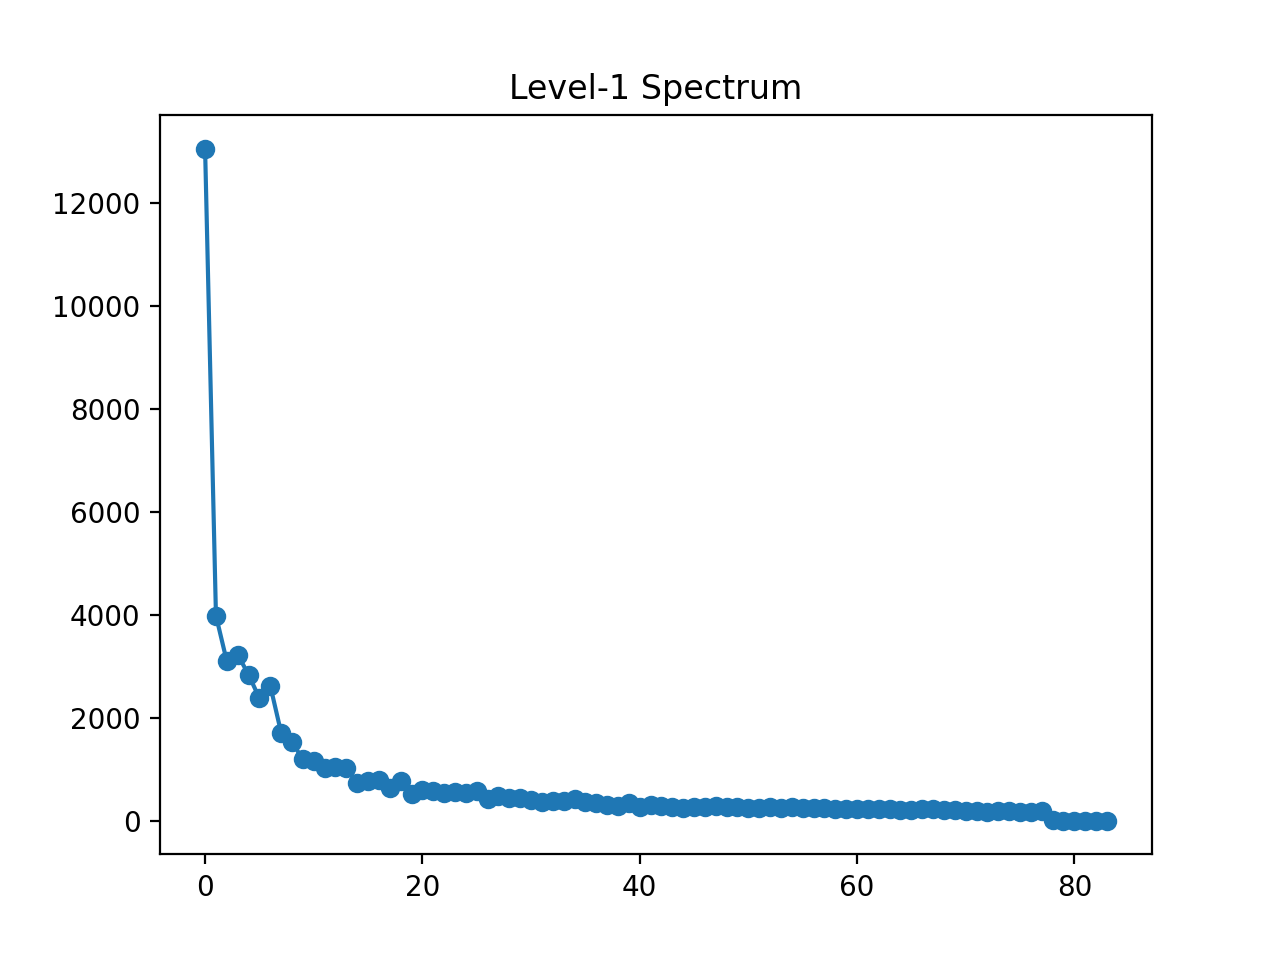

In [27]:
plt.plot(np.diag(S), marker="o")
plt.title("Level-1 Spectrum")
plt.show()

In [9]:
v_proj = X.dot(V.T[:, :7]) # Using effective rank of 7

In [11]:
v_proj.shape

(1114545, 7)

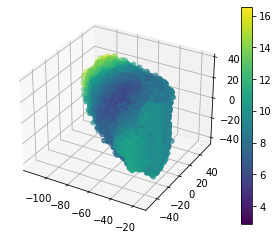

In [79]:
show_scatter(v_proj, e_rmsd)

<IPython.core.display.Javascript object>


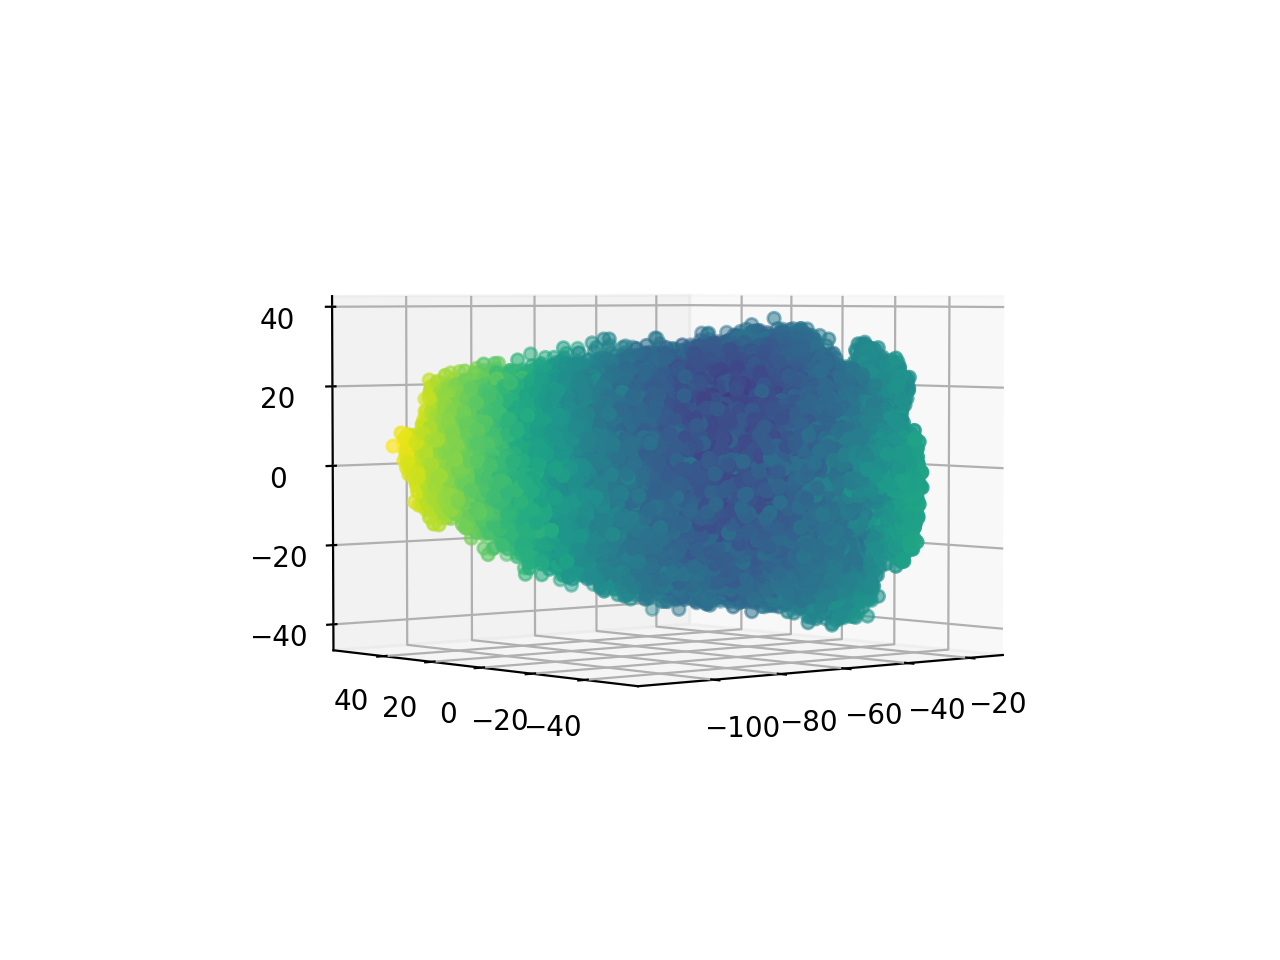

In [16]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(v_proj[:, 0], v_proj[:, 1], v_proj[:, 2], c=e_rmsd)

In [29]:
Sum_of_squared_distances = []
K = range(1, 15)
for k in tqdm(K):
    km = KMeans(n_clusters=k)
    km = km.fit(v_proj)
    Sum_of_squared_distances.append(km.inertia_)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 14/14 [05:10<00:00, 22.16s/it]


<IPython.core.display.Javascript object>


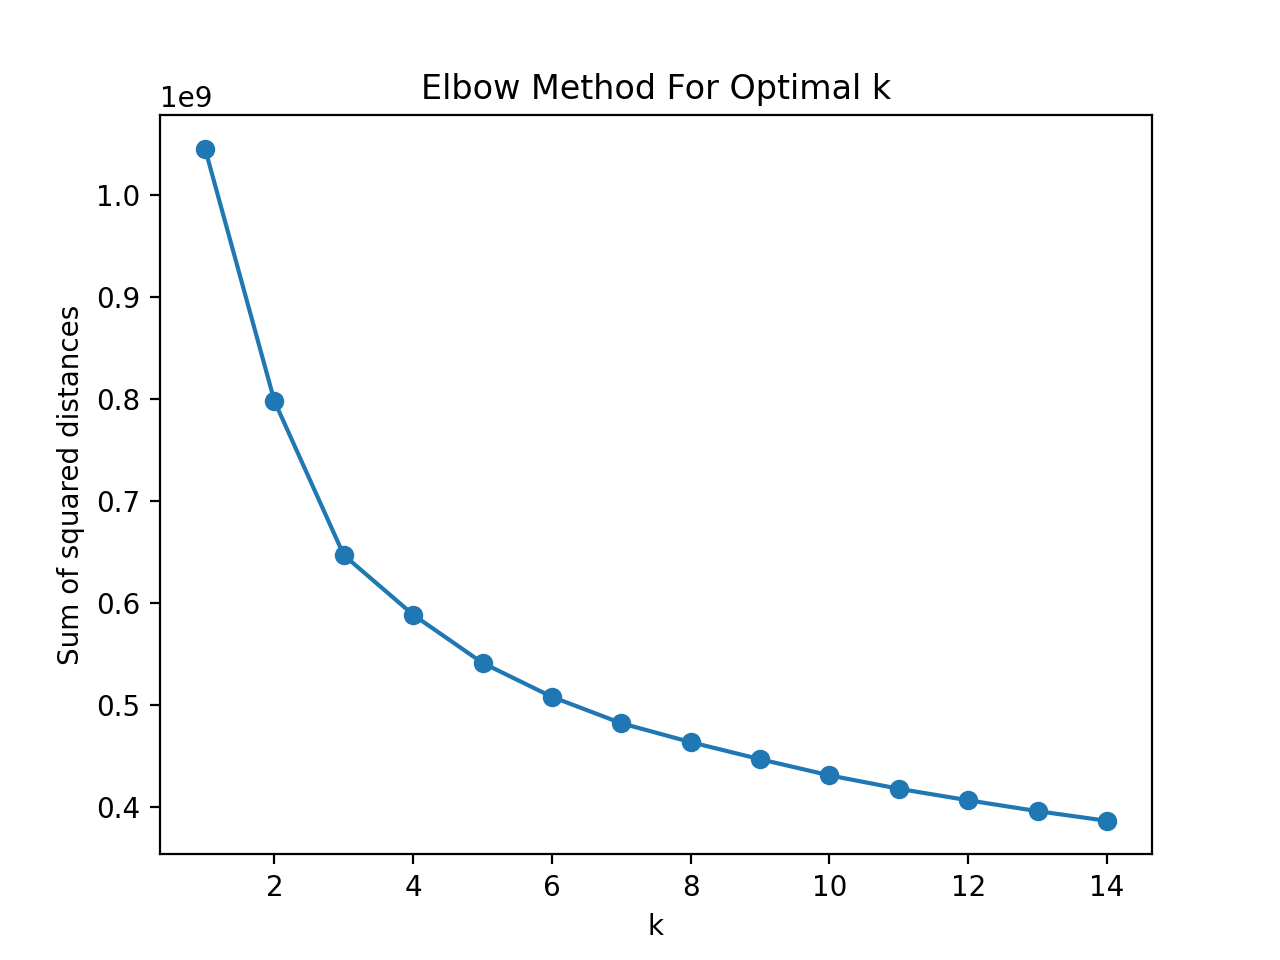

In [39]:
plt.plot(K, Sum_of_squared_distances, 'o-')
plt.xlabel('k')
plt.ylabel('Sum of squared distances')
plt.title('Elbow Method For Optimal k')
plt.show()

In [15]:
km = KMeans(n_clusters=3) # k-means with 3 clusters
km = km.fit(v_proj)

<IPython.core.display.Javascript object>


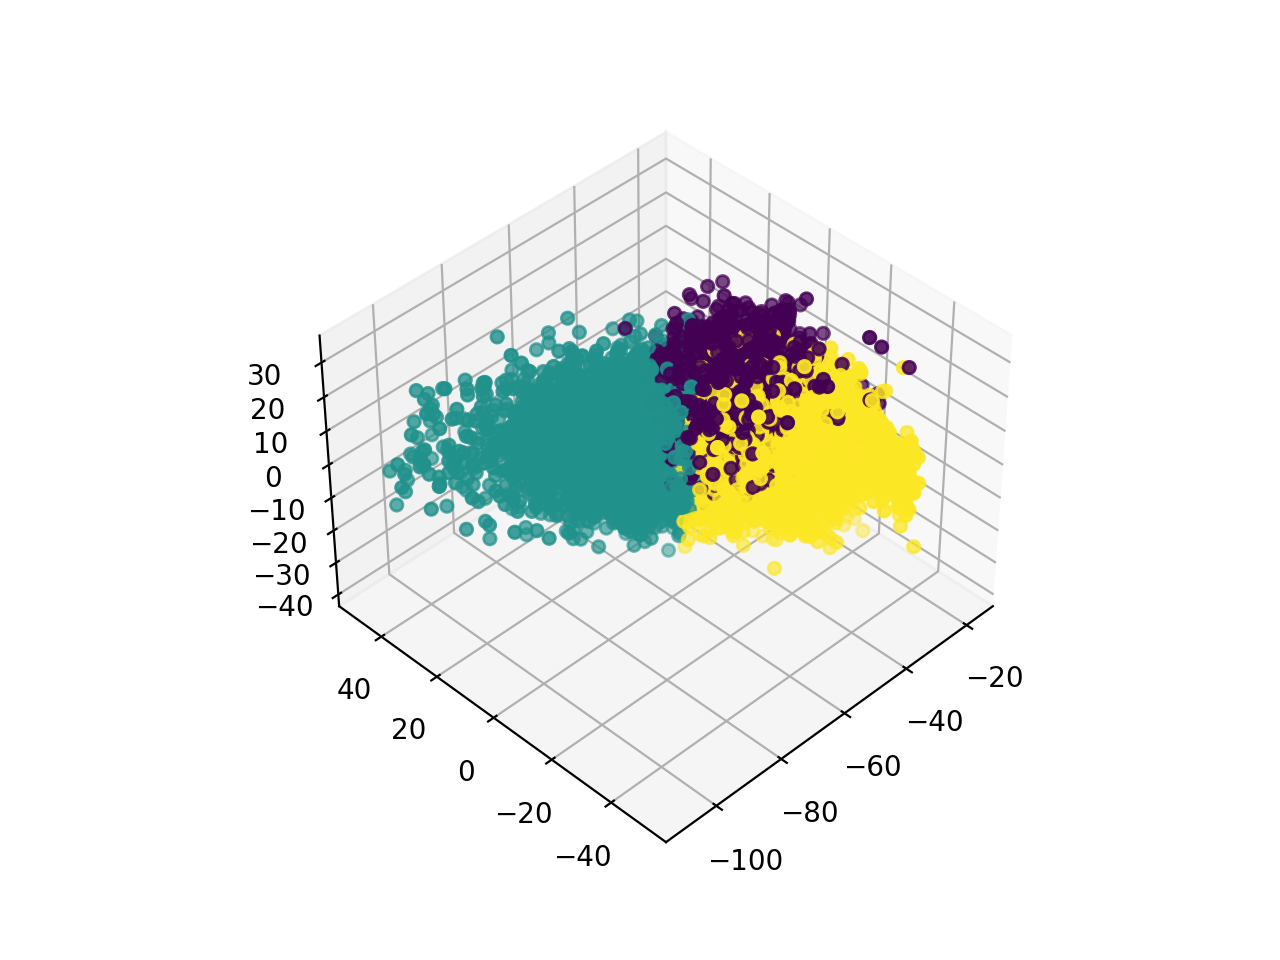

In [51]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(v_proj[::100, 0], v_proj[::100, 1], v_proj[::100, 2], c=km.labels_[::100])

In [34]:
class Hierarchy:
    def __init__(self) -> None:
        self.cluster_inds: Dict[Tuple[int, int], List[np.ndarray]]= defaultdict(list)
        
    def add(self, level: int, cluster: int, inds: np.ndarray) -> None:
        self.cluster_inds[(level, cluster)].append(inds)
    
    
HIERARCHY = Hierarchy()

CLUSTER_INDS = {}

def subsample_factor(num: int) -> int:
    # Evenly subsample data so that SVD
    # does not fail from memory issues
    for i in range(1, num):
        if num / float(i) < 100_000:
            return i
        
def svd_proj(X: np.ndarray, rank_approx: int = 7):
    n, p = X.shape
    
    # Get data
    subsample = subsample_factor(n)
    X_sample = X[::subsample].copy()

    # Run SVD
    _, S, V = svd(X_sample)

    # Project onto row space
    v_proj = X.dot(V.T[:, :rank_approx])
    
    return S, v_proj

def _hierarchical_svd(
    X: np.ndarray,
    inds: np.ndarray,
    rank_approx: int = 7,
    k_clusters: int = 3,
    levels: int = 3,
) -> None:

    if levels == 0:
        return 

    n, p = X.shape
    
    # Get data
    subsample = subsample_factor(n)
    X_sample = X[::subsample].copy()

    # Run SVD
    _, S, V = svd(X_sample)

    # Project onto row space
    v_proj = X.dot(V.T[:, :rank_approx])

    # Cluster projections with k-means
    km = KMeans(n_clusters=k_clusters)
    km = km.fit(v_proj)

    for k in range(k_clusters):
        print(f"Level {levels}, cluster {k}")
        mask = km.labels_ == k
        HIERARCHY.add(levels, k, inds[mask])
        _hierarchical_svd(X[mask], inds[mask], rank_approx, k_clusters, levels - 1)

                         
def hierarchical_svd(X: np.ndarray, rank_approx: int = 7, k_clusters: int = 3, levels: int = 2):
    n, p = X.shape
    inds = np.arange(n)
    _hierarchical_svd(X, inds, rank_approx, k_clusters, levels)
    

In [35]:
hierarchical_svd(X, levels=3)

Level 3, cluster 0
Level 2, cluster 0
Level 1, cluster 0
Level 1, cluster 1
Level 1, cluster 2
Level 2, cluster 1
Level 1, cluster 0
Level 1, cluster 1
Level 1, cluster 2
Level 2, cluster 2
Level 1, cluster 0
Level 1, cluster 1
Level 1, cluster 2
Level 3, cluster 1
Level 2, cluster 0
Level 1, cluster 0
Level 1, cluster 1
Level 1, cluster 2
Level 2, cluster 1
Level 1, cluster 0
Level 1, cluster 1
Level 1, cluster 2
Level 2, cluster 2
Level 1, cluster 0
Level 1, cluster 1
Level 1, cluster 2
Level 3, cluster 2
Level 2, cluster 0
Level 1, cluster 0
Level 1, cluster 1
Level 1, cluster 2
Level 2, cluster 1
Level 1, cluster 0
Level 1, cluster 1
Level 1, cluster 2
Level 2, cluster 2
Level 1, cluster 0
Level 1, cluster 1
Level 1, cluster 2


In [36]:
total = 0
for (level, cluster), ind_list in HIERARCHY.cluster_inds.items():
    print(level, cluster, len(ind_list), [len(i) for i in ind_list])
    total += sum(len(i) for i in ind_list)
total

3 0 1 [407635]
2 0 3 [202317, 159902, 92538]
1 0 9 [90118, 19556, 23914, 48211, 41756, 31632, 30256, 34328, 30900]
1 1 9 [73239, 70525, 33749, 61365, 49968, 33940, 33025, 33951, 26978]
1 2 9 [38960, 26469, 31105, 50326, 55353, 65185, 29257, 35647, 14832]
2 1 3 [116550, 147077, 103926]
2 2 3 [88768, 130757, 72710]
3 1 1 [437736]
3 2 1 [269174]


3343635

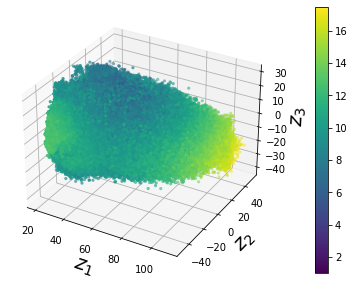

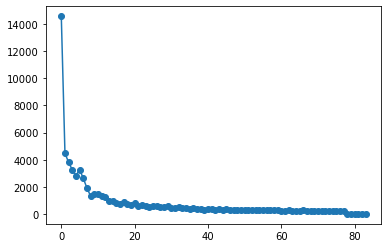

In [39]:
# Full trajectory
S, v_proj = svd_proj(X)
plot_scatter_mpl(v_proj, rmsd_to_native, 
                 cbar_min=cbar_rmsd_min, cbar_max=cbar_rmsd_max, cmap="viridis")
plt.plot(np.diag(S), marker="o")
plt.show()

3 0 407635


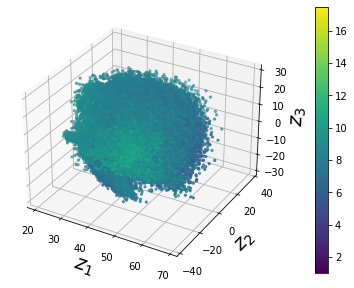

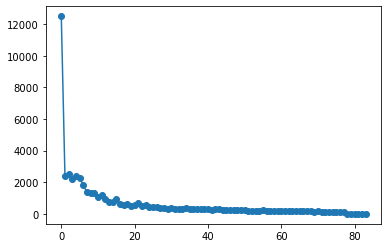

3 1 437736


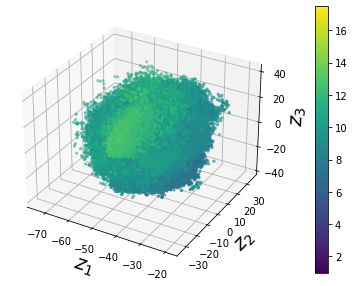

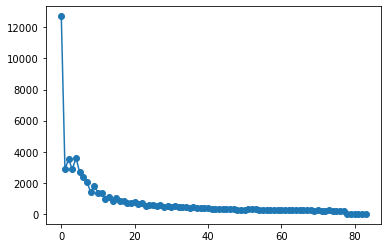

3 2 269174


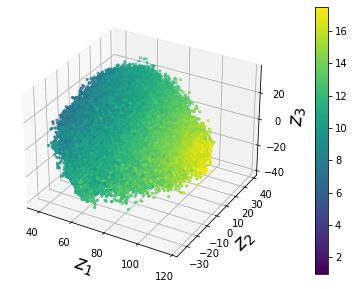

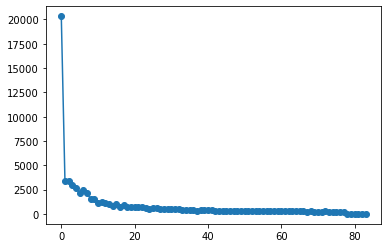

In [37]:
cbar_rmsd_min, cbar_rmsd_max = np.min(rmsd_to_native), np.max(rmsd_to_native)

for (level, cluster), ind_list in HIERARCHY.cluster_inds.items():
    if level == 3:
        for inds in ind_list:
            S, v_proj = svd_proj(X[inds])
            print(level, cluster, len(inds))
            plot_scatter_mpl(v_proj, rmsd_to_native[inds], 
                             cbar_min=cbar_rmsd_min, cbar_max=cbar_rmsd_max, cmap="viridis")
            plt.plot(np.diag(S), marker="o")
            plt.show()

2 0 202317


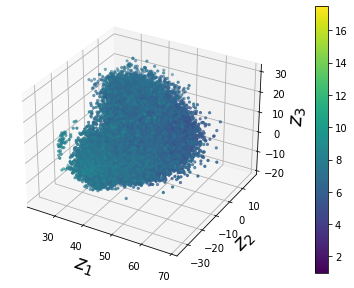

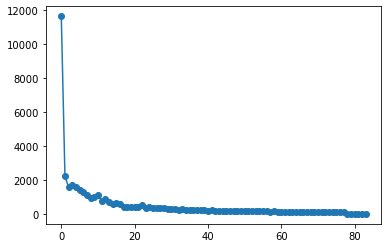

2 0 159902


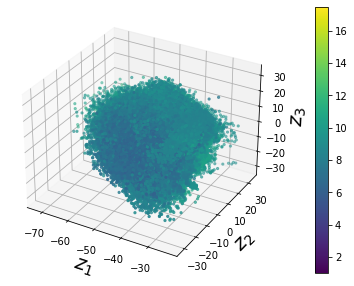

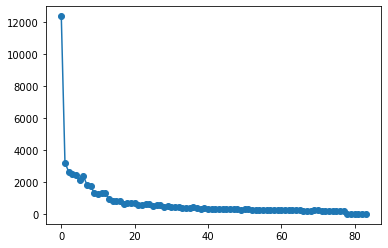

2 0 92538


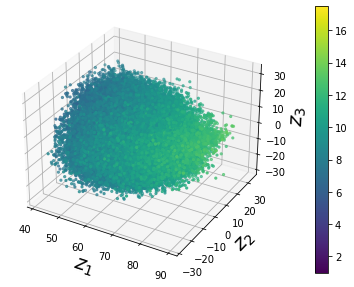

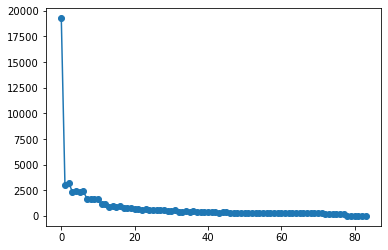

2 1 116550


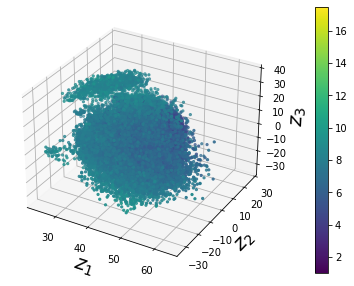

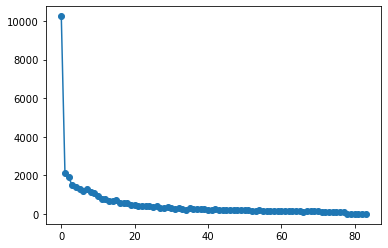

2 1 147077


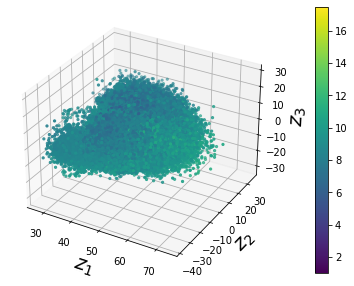

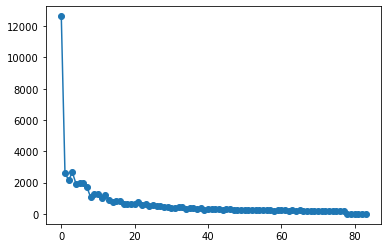

2 1 103926


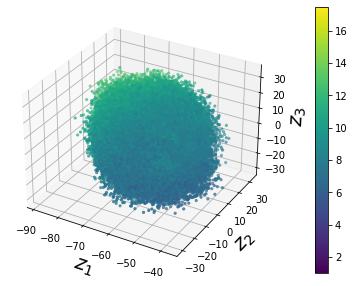

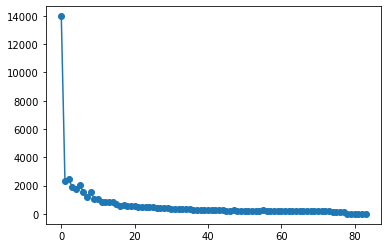

2 2 88768


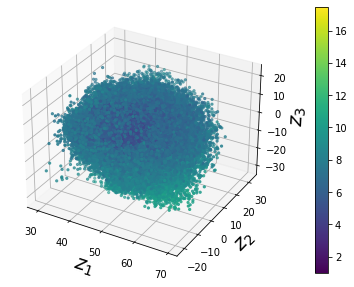

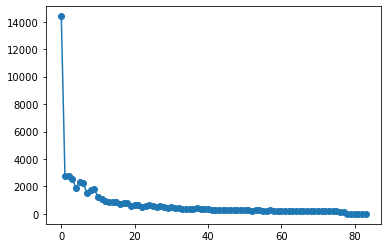

2 2 130757


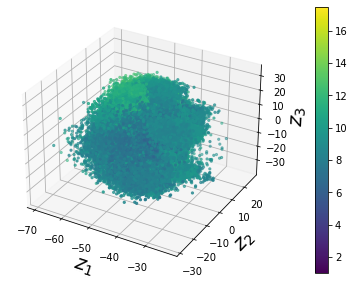

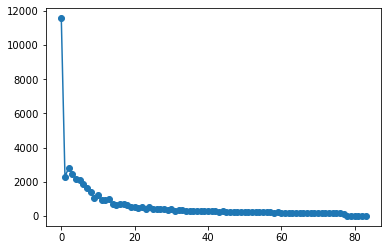

2 2 72710


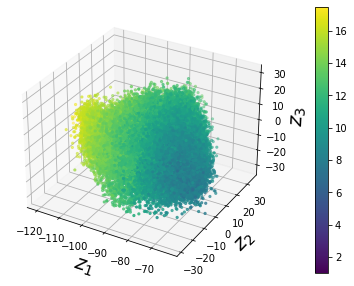

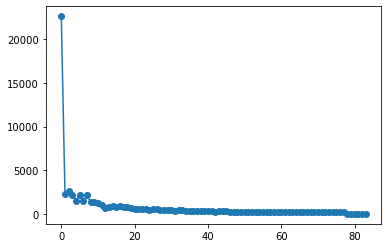

In [40]:
cbar_rmsd_min, cbar_rmsd_max = np.min(rmsd_to_native), np.max(rmsd_to_native)

for (level, cluster), ind_list in HIERARCHY.cluster_inds.items():
    if level == 2:
        for inds in ind_list:
            S, v_proj = svd_proj(X[inds])
            print(level, cluster, len(inds))
            plot_scatter_mpl(v_proj, rmsd_to_native[inds], 
                             cbar_min=cbar_rmsd_min, cbar_max=cbar_rmsd_max, cmap="viridis")
            plt.plot(np.diag(S), marker="o")
            plt.show()

1 0 90118


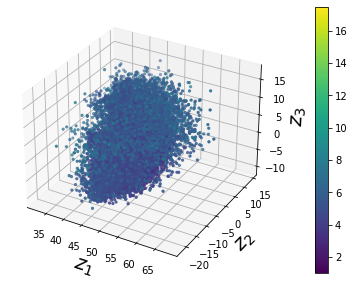

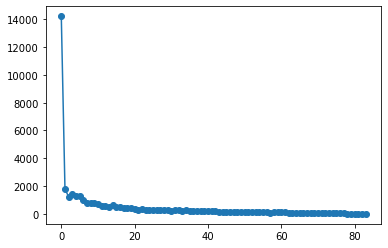

1 0 19556


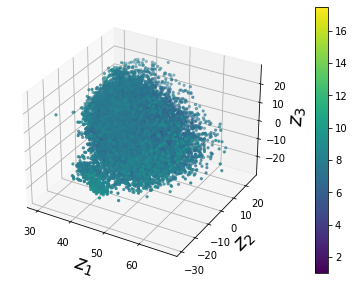

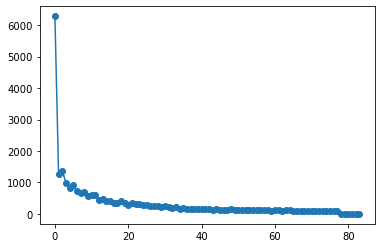

1 0 23914


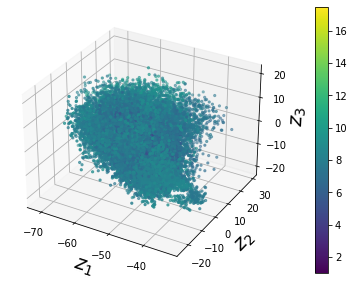

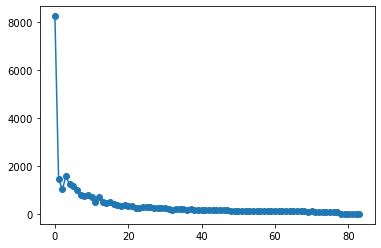

1 0 48211


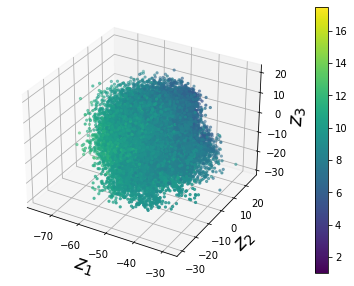

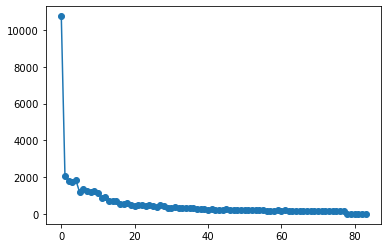

1 0 41756


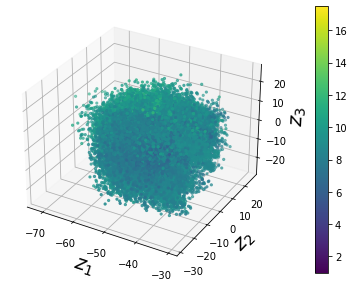

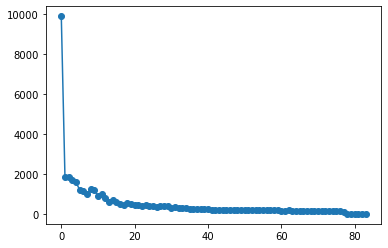

1 0 31632


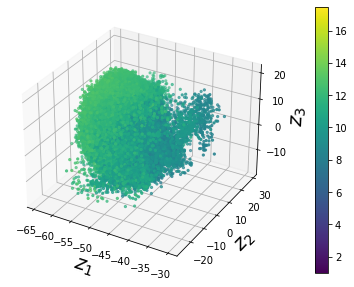

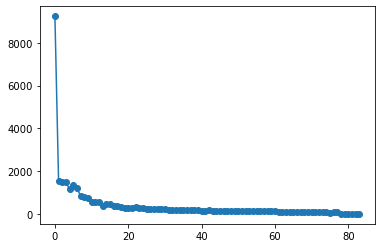

1 0 30256


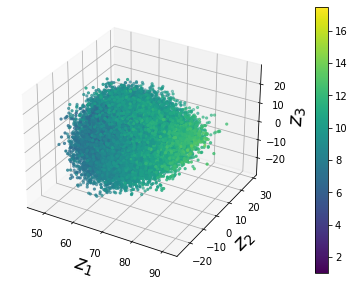

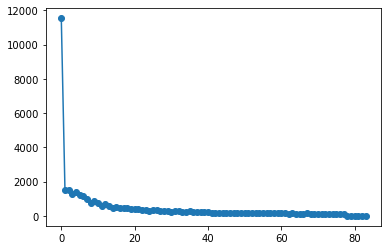

1 0 34328


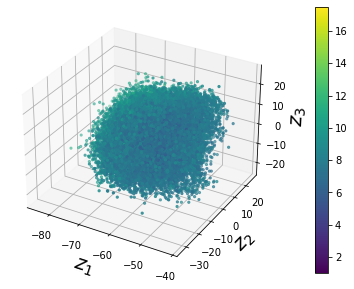

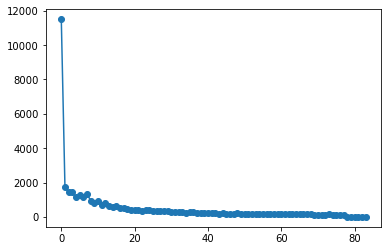

1 0 30900


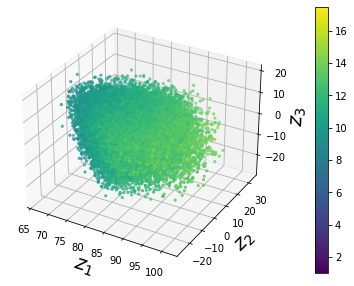

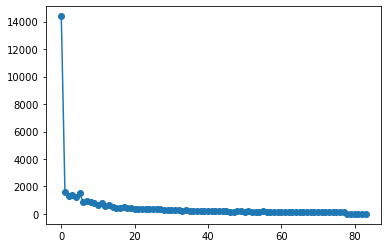

1 1 73239


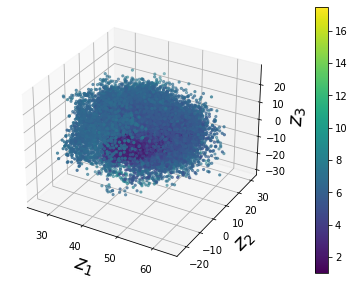

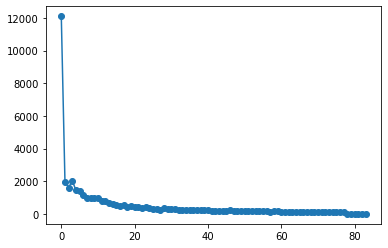

1 1 70525


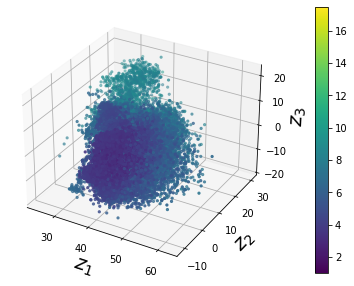

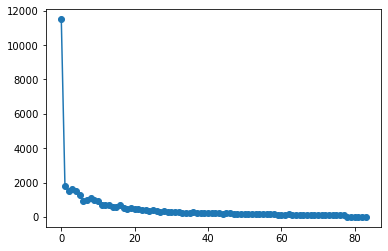

1 1 33749


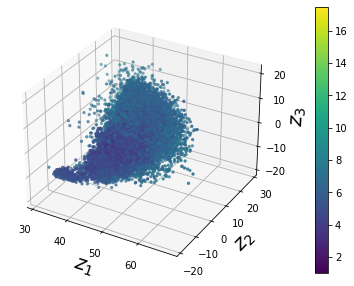

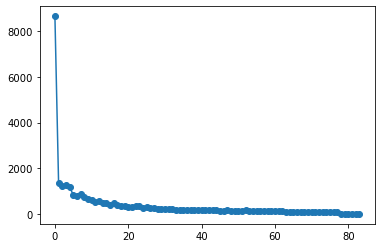

1 1 61365


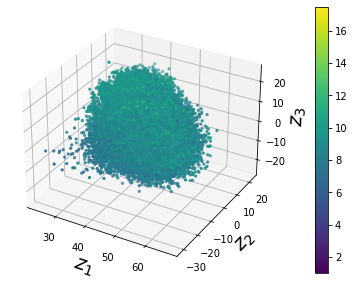

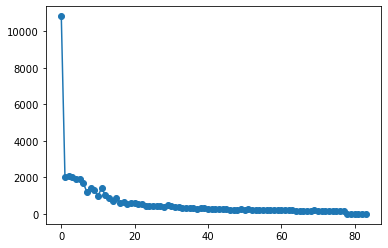

1 1 49968


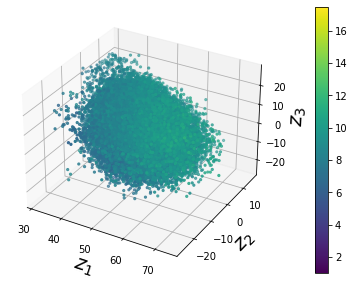

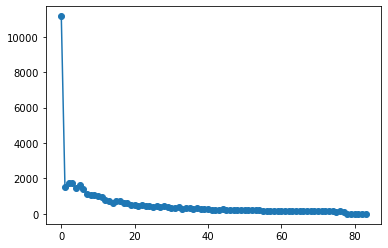

1 1 33940


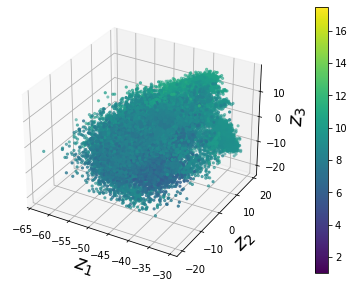

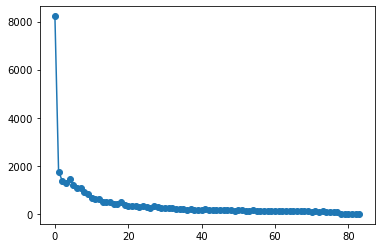

1 1 33025


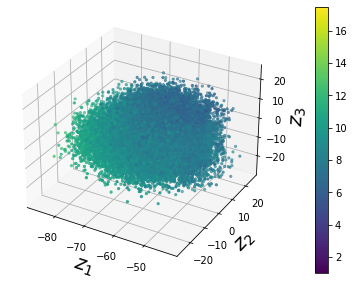

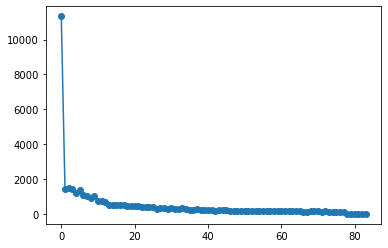

1 1 33951


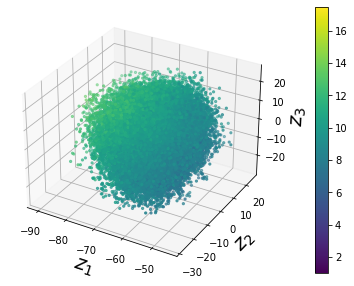

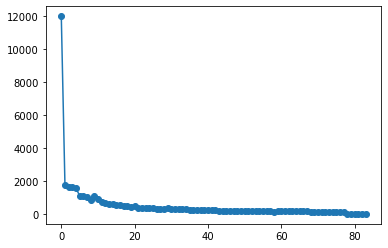

1 1 26978


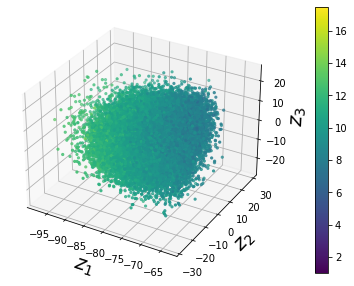

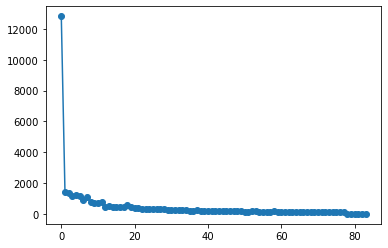

1 2 38960


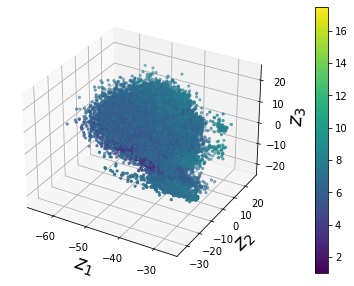

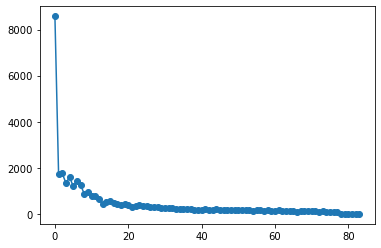

1 2 26469


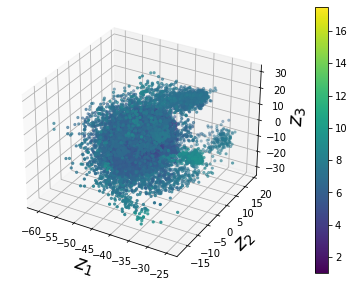

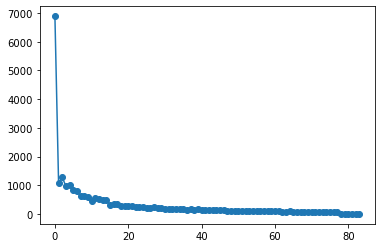

1 2 31105


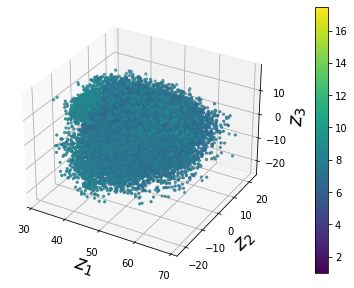

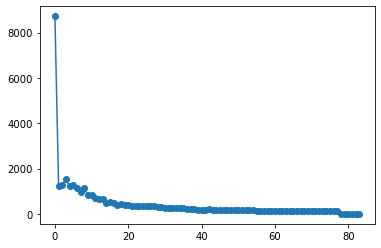

1 2 50326


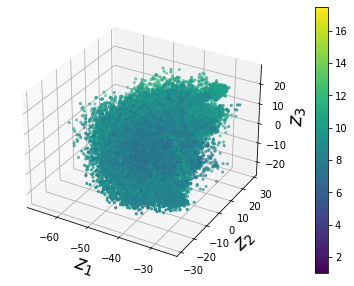

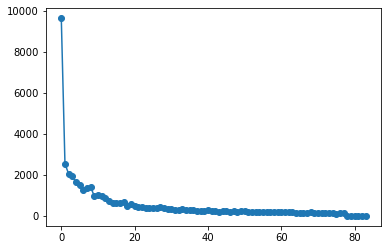

1 2 55353


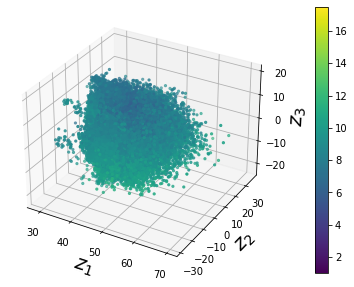

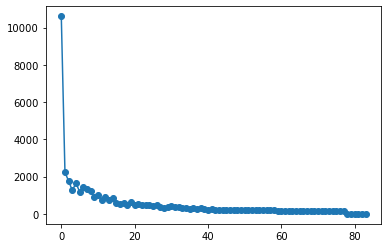

1 2 65185


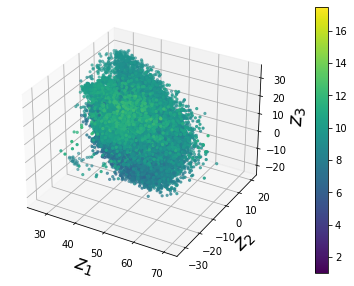

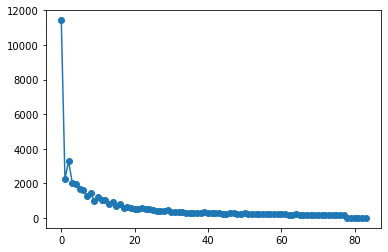

1 2 29257


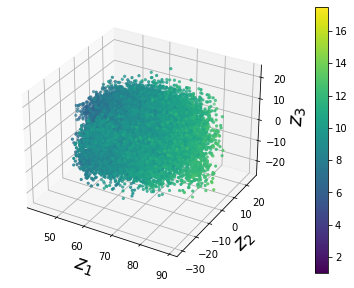

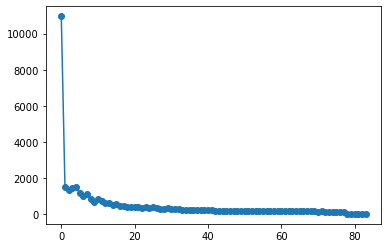

1 2 35647


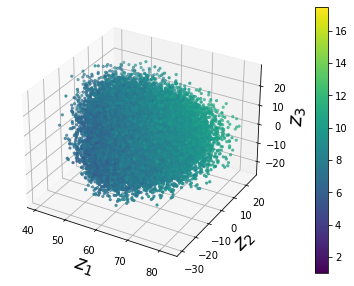

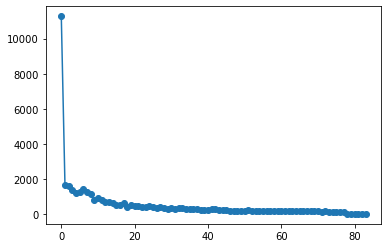

1 2 14832


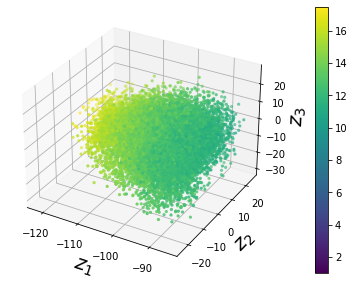

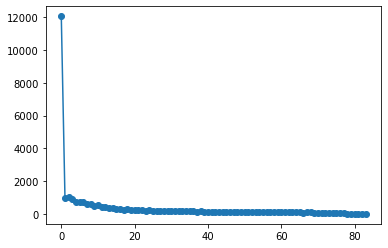

In [41]:
cbar_rmsd_min, cbar_rmsd_max = np.min(rmsd_to_native), np.max(rmsd_to_native)

for (level, cluster), ind_list in HIERARCHY.cluster_inds.items():
    if level == 1:
        for inds in ind_list:
            S, v_proj = svd_proj(X[inds])
            print(level, cluster, len(inds))
            plot_scatter_mpl(v_proj, rmsd_to_native[inds], 
                             cbar_min=cbar_rmsd_min, cbar_max=cbar_rmsd_max, cmap="viridis")
            plt.plot(np.diag(S), marker="o")
            plt.show()

In [ ]:
# Q1: How to find misfolds -- do any exist in the first place?
# Q2: How to combine these projections in interesting ways?